In [196]:
import json 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [155]:
# shapes:
# [input, output], test_start_index
# 0 -> test_start_index - 1: train
# test_start_index -> end: test

def readJson(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    return data

class ARCDataset(Dataset):
    def __init__(self, json_files):
        self.json_files = json_files

    def __len__(self):
        return len(self.json_files)
    
    def __getitem__(self, index):
        file_name = self.json_files[index]
        arc_json_data = readJson(file_name)

        inputs = []
        outputs = []

        for s in arc_json_data['train']:
            inputs.append(self.resize(s['input']))
            outputs.append(self.resize(s['output']))

        for s in arc_json_data['test']:
            inputs.append(self.resize(s['input']))
            outputs.append(self.resize(s['output']))

        inputs = np.array(inputs, dtype=np.int8)
        outputs = np.array(outputs, dtype=np.int8)
        return inputs, outputs, len(arc_json_data['train'])

    def resize(self, array):
        result = np.zeros((30, 30), dtype=np.int8)
        array = np.array(array, dtype=np.int8)
        h, w = array.shape
        result[:h, :w] = array
        return result

In [156]:
cmap = ListedColormap(['#000000', 
                       '#1e92fe', 
                       '#f83c30', 
                       '#4ecd30', 
                       '#fedc01', 
                       '#999999', 
                       '#e53aa3', 
                       '#fe841b', 
                       '#86d9f1', 
                       '#bcbd22'])

def showTrainingImages(inputs, outputs, test_index, width=5, height=7):
    rows = len(inputs[0])
    cols = 2
    _, axs = plt.subplots(rows, cols, figsize=(width, height))

    axs[0, 0].set_title('Example Input')
    axs[0, 1].set_title('Example Output')

    for r in axs:
        for ax in r:
            ax.axis('off')
    
    for i in range(rows):
        axs[i, 0].imshow(inputs[0][i], cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].imshow(outputs[0][i], cmap=cmap, vmin=0, vmax=9)

        if i == test_index:
            axs[i, 0].set_title('Test Input')
            axs[i, 1].set_title('Test Output')

    plt.show()

In [192]:
class Cluster:
    def __init__(self, points):
        self.value = points[0,0]
        self.points = points
        self.centroid = self.calculateCentroid()
        self.lx = np.min(points[:, 0])
        self.ux = np.max(points[:, 0])
        self.ly = np.min(points[:, 1])
        self.uy = np.max(points[:, 1])
    
    def calculateCentroid(self):
        return np.mean(self.points, axis=0)
    
    def __len__(self):
        return len(self.points)

def clusterize(img):
    clusters = []
    visited = np.zeros((30, 30), dtype=np.int8)

    temp_cluster = []
    def floodFill(prev_val, x, y):
        if x < 0 or y < 0 or x >= img.shape[0] or y >= img.shape[1]: return
        if visited[y, x]: return
        if img[y, x] != prev_val: return

        visited[y, x] = 1
        temp_cluster.append((x, y))
        if prev_val == 0:
            # will not consider diagonals for background
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                floodFill(prev_val, x + dx, y + dy)
        else:
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
                floodFill(prev_val, x + dx, y + dy)

    for y in range(30):
        for x in range(30):
            temp_cluster = []
            floodFill(img[y, x], x, y)
            if len(temp_cluster) > 0:
                cluster = Cluster(np.array(temp_cluster))
                clusters.append(cluster)

    return clusters

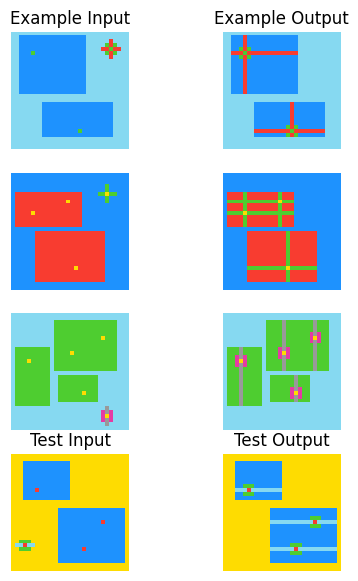

In [212]:
training_dir = './data/training/'
train_file_names = [os.path.join(training_dir, file_name)
                    for file_name in os.listdir(training_dir)]

# training_ds = ARCDataset(train_file_names)
training_ds = ARCDataset([training_dir + '264363fd.json'])
dl = DataLoader(training_ds, batch_size=1, shuffle=False)
inp, out, i = next(iter(dl))
showTrainingImages(inp, out, i)

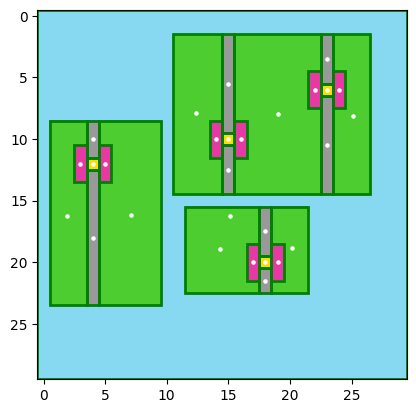

In [231]:
img = out[0][2]
clusters = clusterize(img)
_, ax = plt.subplots()
ax.imshow(img, cmap=cmap, vmin=0, vmax=9)
for c in clusters:
    ax.scatter(c.centroid[0], c.centroid[1], c='w', s=5)
    rect = patches.Rectangle((c.lx - 0.5, c.ly - 0.5), c.ux - c.lx + 1, c.uy - c.ly + 1, linewidth=2, edgecolor='g', facecolor='None')
    ax.add_patch(rect)
plt.show()